In [32]:
import os
import sys
import time
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA


# Using model code from Stutz et.al.
os.chdir("/data/adv_geom/drg/")
from models.classifier import Classifier
from training.train_classifier import TrainClassifier

In [2]:
%tb
args = {
    "train_images_file": "/data/adv_geom/datasets/emnist/train_images.h5",
    "train_codes_file": "/data/adv_geom/datasets/emnist/train_labels.h5",
    "test_images_file": "/data/adv_geom/datasets/emnist/test_images.h5",
    "test_codes_file": "/data/adv_geom/datasets/emnist/test_labels.h5",
    "state_file": "/data/adv_geom/dumps/emnist/classifier.pth.tar",
    "label_index": 0,
    "lr_decay": 0.95,
    "weight_decay": 0.0001,
    "training_samples": 160000,
    "validation_samples": 40000,
    "random_samples": True,
    "network_architecture": "mlp",
    "gpu_id": 1
}

sys.argv = ["-" + i + "=" + str(args[i]) if type(args[i]) != type(True) else "-" + i for i in args]


train_clf = TrainClassifier(args=sys.argv)
train_clf.load_data()
train_clf.load_model_and_scheduler()

No traceback available to show.
[2202211203] -- TrainClassifier
[2202211203] [Training] train_images_file=/data/adv_geom/datasets/emnist/train_images.h5
[2202211203] [Training] train_codes_file=/data/adv_geom/datasets/emnist/train_labels.h5
[2202211203] [Training] test_images_file=/data/adv_geom/datasets/emnist/test_images.h5
[2202211203] [Training] test_codes_file=/data/adv_geom/datasets/emnist/test_labels.h5
[2202211203] [Training] state_file=/data/adv_geom/dumps/emnist/classifier.pth.tar
[2202211203] [Training] log_file=/data/adv_geom/dumps/emnist/classifier.log
[2202211203] [Training] training_file=/data/adv_geom/dumps/emnist/training.h5
[2202211203] [Training] testing_file=/data/adv_geom/dumps/emnist/testing.h5
[2202211203] [Training] loss_file=/data/adv_geom/dumps/emnist/loss.png
[2202211203] [Training] error_file=/data/adv_geom/dumps/emnist/error.png
[2202211203] [Training] gradient_file=/data/adv_geom/dumps/emnist/gradient.png
[2202211203] [Training] label_index=0
[2202211203] 

In [3]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y.long())
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y.long())
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [4]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()

    plt.savefig("test.png")

In [5]:
model = train_clf.model
X_test = torch.Tensor(train_clf.test_images)
y_test = torch.Tensor(train_clf.test_codes)


In [6]:
"""
Finding nearest neighbours on the manifold
Reference: https://github.com/davidstutz/disentangling-robustness-generalization/blob/220ff8a79a5f08665f4755dc76d4e592ae66c6d6/training/test_attack_classifier.py#L154
"""

'\nFinding nearest neighbours on the manifold\nReference: https://github.com/davidstutz/disentangling-robustness-generalization/blob/220ff8a79a5f08665f4755dc76d4e592ae66c6d6/training/test_attack_classifier.py#L154\n'

In [7]:
X_train = train_clf.train_images
y_train = train_clf.train_codes

# Training a PCA model on randomly sampled 10000 images from the training set
num_img_to_fit = 10000
idx = np.random.randint(0, X_train.shape[0], size=num_img_to_fit)

pca = IncrementalPCA(n_components=20) # n_components taken from David Stutz's code
pca.fit(X_train[idx].reshape(X_train[idx].shape[0], -1))

IncrementalPCA(n_components=20)

In [31]:
# Transforming the training set based on the learned PCA model 
# Note: These will be used to approximate the manifold, since these
# are what the classifier has been trained on
X_train_latent = pca.transform(X_train.reshape(X_train.shape[0], -1))

# Fitting a Nearest Neighbors object on the transformed latent samples
NN = NearestNeighbors(n_neighbors=50, algorithm='kd_tree')
NN.fit(X_train_latent)



NearestNeighbors(algorithm='kd_tree', n_neighbors=50)

In [57]:
# Pick a perturbed sample
ridx = np.random.randint(0, X_train.shape[0], size=(1,6))[0]
rimg = X_train[ridx]
rcode = y_train[ridx]

In [60]:
rimg.shape

(6, 28, 28, 1)

In [61]:
rimg = torch.Tensor(rimg)
rcode = torch.Tensor(rcode)

In [70]:
model.cuda()
rimg = rimg.cuda()
rcode = rcode.cuda()
delta = pgd_linf_rand(model, rimg, rcode, 0.1, 1e-2, 40, 10)
model.cpu()
rimg = rimg.cpu()
rcode = rcode.cpu()


In [71]:
model.cuda()
with torch.no_grad():
    
    yp = model(rimg.cuda() + delta.cuda())
    
    model.cpu()

In [65]:
# X = torch.Tensor(train_clf.train_images)
# y = torch.Tensor(train_clf.train_codes).long()
# model.cuda()
# X = X.cuda()
# y = y.cuda()
# delta = pgd_linf_rand(model, X[:1], y[:1], 0.1, 1e-2, 40, 10)
# model.cpu()
# X = X.cpu()
# y = y.cpu()

In [72]:
yp.shape, rimg.shape, rcode.shape

(torch.Size([6, 10]), torch.Size([6, 28, 28, 1]), torch.Size([6]))

In [15]:
plot_images(X[:6], y[:6], yp[:6], 2, 3)




here


torch.Size([28, 28, 1])

In [34]:
a = np.arange(10)
plt.plot(a)
plt.show()

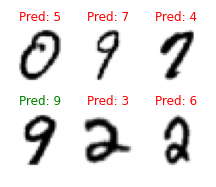

In [11]:
from IPython.display import Image
Image(filename='test.png') 

In [44]:
(1-X[:6][0*3+0][0]).shape

torch.Size([28, 1])

In [13]:
X[0].shape

torch.Size([28, 28, 1])

(1, 28, 28, 1)

In [17]:
rimg.shape

(28, 28, 1)